# Team Project

- Type: a competition-based project with a leader board (training datasets is released on lecture's kaggle competition page)

- Objective: maximizing the test accuracy under the condition:
    - part-1: under 2,000,000 (2M) parameters
    - part-2: less than # of parameters in part-1 (detailed information will be noticed)

- Period:
    - part-1: 5th Oct. to 16th Nov.
    - part-2: 25th Nov. to 16th Dec.

- Evaluations: mid-term rank (5%), final rank (5%), reports and presentations (30%)

- Additional points
    - (a) the highest ranked 6 teams - they are requested to present their methods and release the source codes
    - (b) teams whose approaches are novel and effective will be recommended to submit the outputs to conference

## CAUTION

- You can change **only** the **[Define Model](#scrollTo=9ViRr0JT84C7)**, **[Train Model](#scrollTo=NSFY5dyOm-qA)** and **[Hyperparameters](#scrollTo=Pv-hIWaJomEf)** sections.
- You can use any kind of deep neural networks and apply any optimization techniques to improve the performance.

## Mount Google Drive and Download training&test datasets

First, Download datasets from [this lecture's kaggle competition page](https://www.kaggle.com/t/a5ea909a4294477d82a1ba88c10abe61) and upload your Google Drive.

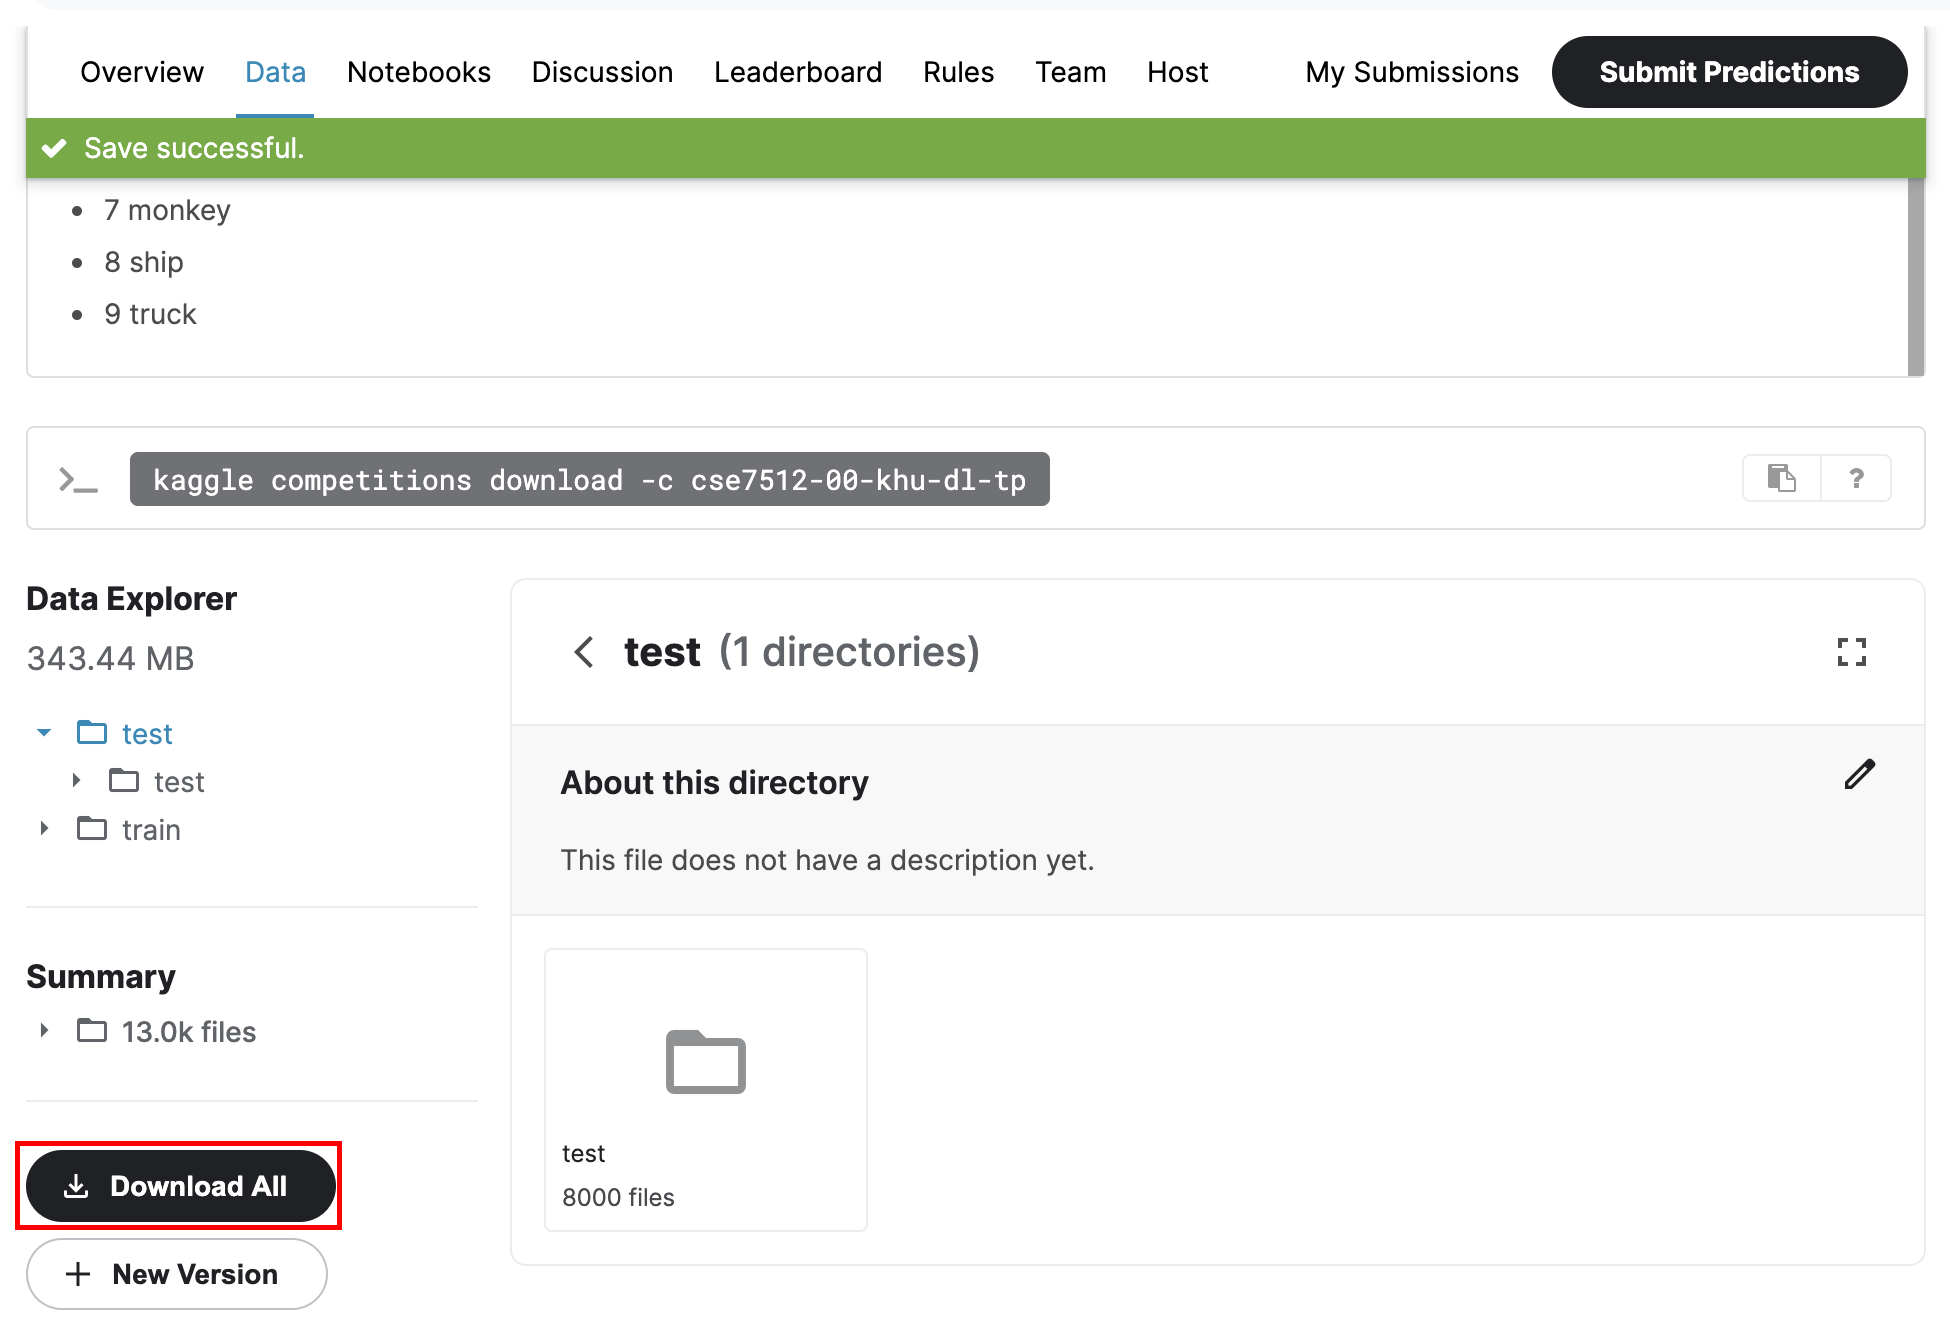

**You shuold upload dataset zip file to `My Drive/CSIE7512_DL_Project/`.**

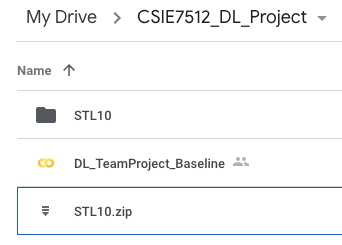

Then, mount your google drive on this session.

In [ ]:

from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### mount google drive example

1. Execute the mount cell and click that https URL below picture  
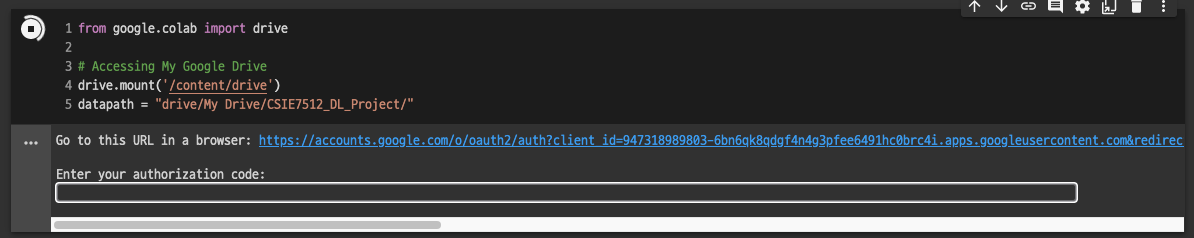

2. Click your account  
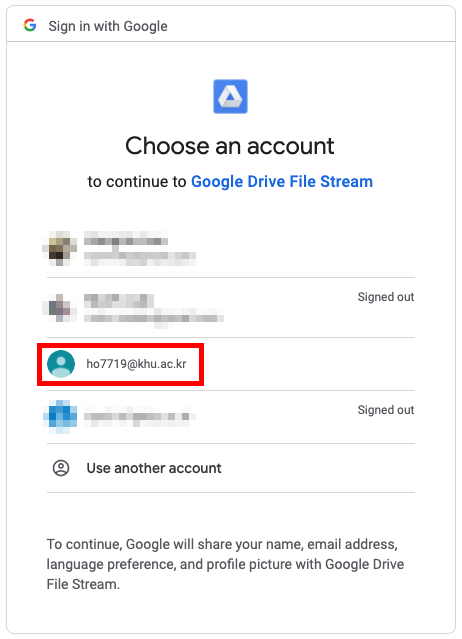

3. Click allow button  
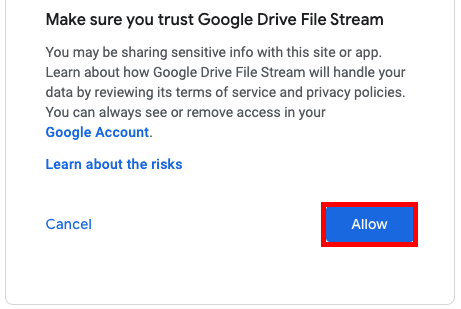

4. Copy the authorization code  
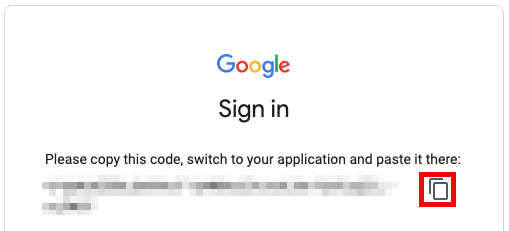


5. Enter the authorization code   
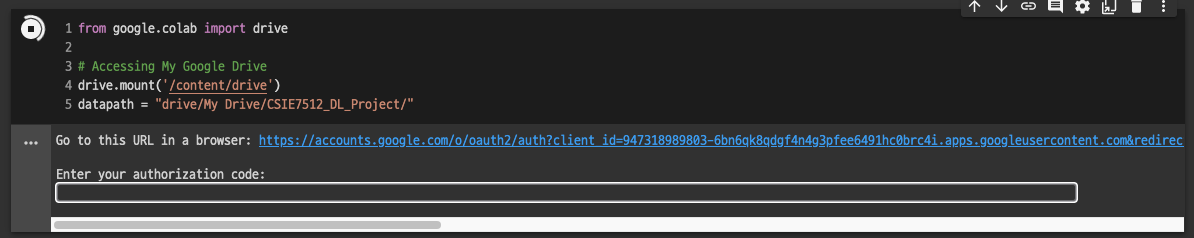

6. Done!  
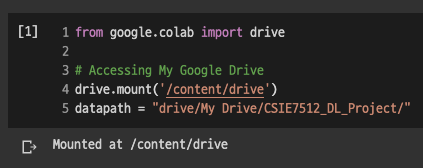

## Unzip dataset on runtime session

In [ ]:
!unzip '/content/drive/My Drive/CSIE7512_DL_Project/STL10.zip'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: valid/cat/6003.bmp      
  inflating: valid/cat/6013.bmp      
  inflating: valid/cat/6030.bmp      
  inflating: valid/cat/6046.bmp      
  inflating: valid/cat/6048.bmp      
  inflating: valid/cat/6057.bmp      
  inflating: valid/cat/6063.bmp      
  inflating: valid/cat/6083.bmp      
  inflating: valid/cat/6094.bmp      
  inflating: valid/cat/6129.bmp      
  inflating: valid/cat/6155.bmp      
  inflating: valid/cat/6174.bmp      
  inflating: valid/cat/6197.bmp      
  inflating: valid/cat/6204.bmp      
  inflating: valid/cat/6209.bmp      
  inflating: valid/cat/6215.bmp      
  inflating: valid/cat/6228.bmp      
  inflating: valid/cat/6235.bmp      
  inflating: valid/cat/6237.bmp      
  inflating: valid/cat/6246.bmp      
  inflating: valid/cat/6249.bmp      
  inflating: valid/cat/6257.bmp      
  inflating: valid/cat/6260.bmp      
  inflating: valid/cat/6287.bmp      
  inflating: valid/cat/6305.bmp      
  inflating: v

## Define Model

In [ ]:
import torch
import torch.nn as nn


class LeNet_STL10(nn.Module):
    def __init__(self):
        super(LeNet_STL10, self).__init__()
        self.num_classes = 10

        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d((2, 2), stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d((2, 2), stride=2)
        self.fc1 = nn.Linear(16*21*21, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, self.num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x


def Model():
    r"""Return your custom model
    """
    return LeNet_STL10()

#Rexnet

In [ ]:
"""
ReXNet
Copyright (c) 2020-present NAVER Corp.
MIT license
"""

import torch
import torch.nn as nn
from math import ceil

#Mish activation
import torch.nn.functional as F
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return mish(input)
        
# Memory-efficient Siwsh using torch.jit.script borrowed from the code in (https://twitter.com/jeremyphoward/status/1188251041835315200)
# Currently use memory-efficient Swish as default:
USE_MEMORY_EFFICIENT_SWISH = True

if USE_MEMORY_EFFICIENT_SWISH:
    @torch.jit.script
    def swish_fwd(x):
        return x.mul(torch.sigmoid(x))


    @torch.jit.script
    def swish_bwd(x, grad_output):
        x_sigmoid = torch.sigmoid(x)
        return grad_output * (x_sigmoid * (1. + x * (1. - x_sigmoid)))


    class SwishJitImplementation(torch.autograd.Function):
        @staticmethod
        def forward(ctx, x):
            ctx.save_for_backward(x)
            return swish_fwd(x)

        @staticmethod
        def backward(ctx, grad_output):
            x = ctx.saved_tensors[0]
            return swish_bwd(x, grad_output)


    def swish(x, inplace=False):
        return SwishJitImplementation.apply(x)

else:
    def swish(x, inplace=False):
        return x.mul_(x.sigmoid()) if inplace else x.mul(x.sigmoid())


class Swish(nn.Module):
    def __init__(self, inplace=True):
        super(Swish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return swish(x, self.inplace)


def ConvBNAct(out, in_channels, channels, kernel=1, stride=1, pad=0,
              num_group=1, active=True, relu6=False):
    out.append(nn.Conv2d(in_channels, channels, kernel,
                         stride, pad, groups=num_group, bias=False))
    out.append(nn.BatchNorm2d(channels))
    if active:
        out.append(nn.ReLU6(inplace=True) if relu6 else nn.ReLU(inplace=True))


def ConvBNSwish(out, in_channels, channels, kernel=1, stride=1, pad=0, num_group=1):
    out.append(nn.Conv2d(in_channels, channels, kernel,
                         stride, pad, groups=num_group, bias=False))
    out.append(nn.BatchNorm2d(channels))
    out.append(Swish())


class SE(nn.Module):
    def __init__(self, in_channels, channels, se_ratio=12):
        super(SE, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, channels // se_ratio, kernel_size=1, padding=0),
            nn.BatchNorm2d(channels // se_ratio),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // se_ratio, channels, kernel_size=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.fc(y)
        return x * y


class LinearBottleneck(nn.Module):
    def __init__(self, in_channels, channels, t, stride, use_se=True, se_ratio=12,
                 **kwargs):
        super(LinearBottleneck, self).__init__(**kwargs)
        self.use_shortcut = stride == 1 and in_channels <= channels
        self.in_channels = in_channels
        self.out_channels = channels

        out = []
        if t != 1:
            dw_channels = in_channels * t
            ConvBNSwish(out, in_channels=in_channels, channels=dw_channels)
        else:
            dw_channels = in_channels

        ConvBNAct(out, in_channels=dw_channels, channels=dw_channels, kernel=3, stride=stride, pad=1,
                  num_group=dw_channels, active=False)

        if use_se:
            out.append(SE(dw_channels, dw_channels, se_ratio))

        out.append(nn.ReLU6())
        ConvBNAct(out, in_channels=dw_channels, channels=channels, active=False, relu6=True)
        self.out = nn.Sequential(*out)

    def forward(self, x):
        out = self.out(x)
        if self.use_shortcut:
            out[:, 0:self.in_channels] += x

        return out


class ReXNetV1(nn.Module):
    def __init__(self, input_ch=16, final_ch=180, width_mult=1.0, depth_mult=1.0, classes=10,
                 use_se=True,
                 se_ratio=12,
                 dropout_ratio=0.2,
                 bn_momentum=0.9):
        super(ReXNetV1, self).__init__()

        #layers = [2, 2, 2, 3, 3, 4]
        layers = [1, 2, 2, 2, 2, 1]
        strides = [1, 1, 2, 2, 1, 2]
        use_ses = [False, False, True, True, True, True]

        layers = [ceil(element * depth_mult) for element in layers]
        strides = sum([[element] + [1] * (layers[idx] - 1)
                       for idx, element in enumerate(strides)], [])
        if use_se:
            use_ses = sum([[element] * layers[idx] for idx, element in enumerate(use_ses)], [])
        else:
            use_ses = [False] * sum(layers[:])
        ts = [1] * layers[0] + [6] * sum(layers[1:])

        self.depth = sum(layers[:]) * 3
        stem_channel = 32 / width_mult if width_mult < 1.0 else 32
        inplanes = input_ch / width_mult if width_mult < 1.0 else input_ch

        features = []
        in_channels_group = []
        channels_group = []

        # The following channel configuration is a simple instance to make each layer become an expand layer.
        for i in range(self.depth // 3):
            if i == 0:
                in_channels_group.append(int(round(stem_channel * width_mult)))
                channels_group.append(int(round(inplanes * width_mult)))
            else:
                in_channels_group.append(int(round(inplanes * width_mult)))
                inplanes += final_ch / (self.depth // 3 * 1.0)
                channels_group.append(int(round(inplanes * width_mult)))

        ConvBNSwish(features, 3, int(round(stem_channel * width_mult)), kernel=3, stride=1, pad=1)

        for block_idx, (in_c, c, t, s, se) in enumerate(zip(in_channels_group, channels_group, ts, strides, use_ses)):
            features.append(LinearBottleneck(in_channels=in_c,
                                             channels=c,
                                             t=t,
                                             stride=s,
                                             use_se=se, se_ratio=se_ratio))

        pen_channels = int(1280 * width_mult)
        ConvBNSwish(features, c, pen_channels)

        features.append(nn.AdaptiveAvgPool2d(1))
        self.features = nn.Sequential(*features)
        self.output = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Conv2d(pen_channels, classes, 1, bias=True))

    def forward(self, x):
        x = self.features(x)
        x = self.output(x).squeeze()
        return x

#Resnet for CIFAR10

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable

__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

def conv3x3(in_planes, out_planes, stride=1):
    " 3x3 convolution with padding "
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion=1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        # x = F.relu(x)
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet_Cifar(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_Cifar, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(64, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, planes, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet_Cifar(BasicBlock, [3, 3, 3])

def resnet32():
    return ResNet_Cifar(BasicBlock, [5, 5, 5])

def resnet44():
    return ResNet_Cifar(BasicBlock, [7, 7, 7])

def resnet56():
    return ResNet_Cifar(BasicBlock, [9, 9, 9])

def resnet110():
    return ResNet_Cifar(BasicBlock, [18, 18, 18])

net = resnet110()
num_parameters = sum(l.numel() for l in net.parameters())
print(num_parameters)

1730714


#Wide Resnet (Imagenet)

In [ ]:
import torch
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 32.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 32
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        #self.layer4 = self._make_layer(block, 256, layers[3], stride=2,
        #                               dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    return _resnet(BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    return _resnet(BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    return _resnet(Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    return _resnet(Bottleneck, [3, 4, 13, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext32_32x2d(pretrained=False, progress=True, **kwargs):
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 2
    return _resnet(Bottleneck, [5, 5, 5],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet(Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    kwargs['width_per_group'] = 64 * 2
    return _resnet(Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)

def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    kwargs['width_per_group'] = 64 * 2
    return _resnet(Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

#CosineAnnealing warmup

In [ ]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = 0.1 - lr

#mobilenet V2

In [ ]:

import torch.nn as nn
import math

__all__ = ['mobilenetv2']


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10, width_mult=1.0):
        super(MobileNetV2, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = [
            # t, c, n, s
            [1,  16, 1, 1],
            [6,  24, 2, 2],
            [6,  32, 3, 2],
            [6,  64, 4, 2],
            [6,  96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        input_channel = _make_divisible(32 * width_mult, 4 if width_mult == 0.1 else 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = InvertedResidual
        for t, c, n, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 4 if width_mult == 0.1 else 8)
            for i in range(n):
                layers.append(block(input_channel, output_channel, s if i == 0 else 1, t))
                input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        output_channel = _make_divisible(1280 * width_mult, 4 if width_mult == 0.1 else 8) if width_mult > 1.0 else 1280
        self.conv = conv_1x1_bn(input_channel, output_channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(output_channel, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

def mobilenetv2(**kwargs):
    """
    Constructs a MobileNet V2 model
    """
    return MobileNetV2(**kwargs)

#MobileNet V3

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


__all__ = ['MobileNetV3', 'mobilenetv3']


def conv_bn(inp, oup, stride, conv_layer=nn.Conv2d, norm_layer=nn.BatchNorm2d, nlin_layer=nn.ReLU):
    return nn.Sequential(
        conv_layer(inp, oup, 3, stride, 1, bias=False),
        norm_layer(oup),
        nlin_layer(inplace=True)
    )


def conv_1x1_bn(inp, oup, conv_layer=nn.Conv2d, norm_layer=nn.BatchNorm2d, nlin_layer=nn.ReLU):
    return nn.Sequential(
        conv_layer(inp, oup, 1, 1, 0, bias=False),
        norm_layer(oup),
        nlin_layer(inplace=True)
    )


class Hswish(nn.Module):
    def __init__(self, inplace=True):
        super(Hswish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return x * F.relu6(x + 3., inplace=self.inplace) / 6.


class Hsigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(Hsigmoid, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return F.relu6(x + 3., inplace=self.inplace) / 6.


class SEModule(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            Hsigmoid()
            # nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class Identity(nn.Module):
    def __init__(self, channel):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class MobileBottleneck(nn.Module):
    def __init__(self, inp, oup, kernel, stride, exp, se=False, nl='RE'):
        super(MobileBottleneck, self).__init__()
        assert stride in [1, 2]
        assert kernel in [3, 5]
        padding = (kernel - 1) // 2
        self.use_res_connect = stride == 1 and inp == oup

        conv_layer = nn.Conv2d
        norm_layer = nn.BatchNorm2d
        if nl == 'RE':
            nlin_layer = nn.ReLU # or ReLU6
        elif nl == 'HS':
            nlin_layer = Hswish
        else:
            raise NotImplementedError
        if se:
            SELayer = SEModule
        else:
            SELayer = Identity

        self.conv = nn.Sequential(
            # pw
            conv_layer(inp, exp, 1, 1, 0, bias=False),
            norm_layer(exp),
            nlin_layer(inplace=True),
            # dw
            conv_layer(exp, exp, kernel, stride, padding, groups=exp, bias=False),
            norm_layer(exp),
            SELayer(exp),
            nlin_layer(inplace=True),
            # pw-linear
            conv_layer(exp, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV3(nn.Module):
    def __init__(self, n_class=10, input_size=96, dropout=0.8, mode='small', width_mult=1.08):
        super(MobileNetV3, self).__init__()
        input_channel = 16
        last_channel = 1280
        if mode == 'large':
            # refer to Table 1 in paper
            mobile_setting = [
                # k, exp, c,  se,     nl,  s,
                [3, 16,  16,  False, 'RE', 1],
                [3, 64,  24,  False, 'RE', 2],
                [3, 72,  24,  False, 'RE', 1],
                [5, 72,  40,  True,  'RE', 2],
                [5, 120, 40,  True,  'RE', 1],
                [5, 120, 40,  True,  'RE', 1],
                [3, 240, 80,  False, 'HS', 2],
                [3, 200, 80,  False, 'HS', 1],
                [3, 184, 80,  False, 'HS', 1],
                [3, 184, 80,  False, 'HS', 1],
                [3, 480, 112, True,  'HS', 1],
                [3, 672, 112, True,  'HS', 1],
                [5, 672, 160, True,  'HS', 2],
                [5, 960, 160, True,  'HS', 1],
                [5, 960, 160, True,  'HS', 1],
            ]
        elif mode == 'small':
            # refer to Table 2 in paper
            mobile_setting = [
                # k, exp, c,  se,     nl,  s,
                [3, 16,  16,  True,  'RE', 2],
                [3, 72,  24,  False, 'RE', 2],
                [3, 88,  24,  False, 'RE', 1],
                [5, 96,  40,  True,  'HS', 2],
                [5, 240, 40,  True,  'HS', 1],
                [5, 240, 40,  True,  'HS', 1],
                [5, 120, 48,  True,  'HS', 1],
                [5, 144, 48,  True,  'HS', 1],
                [5, 288, 96,  True,  'HS', 2],
                [5, 576, 96,  True,  'HS', 1],
                [5, 576, 96,  True,  'HS', 1],
            ]
        else:
            raise NotImplementedError

        # building first layer
        assert input_size % 32 == 0
        last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2, nlin_layer=Hswish)]
        self.classifier = []

        # building mobile blocks
        for k, exp, c, se, nl, s in mobile_setting:
            output_channel = make_divisible(c * width_mult)
            exp_channel = make_divisible(exp * width_mult)
            self.features.append(MobileBottleneck(input_channel, output_channel, k, s, exp_channel, se, nl))
            input_channel = output_channel

        # building last several layers
        if mode == 'large':
            last_conv = make_divisible(960 * width_mult)
            self.features.append(conv_1x1_bn(input_channel, last_conv, nlin_layer=Hswish))
            self.features.append(nn.AdaptiveAvgPool2d(1))
            self.features.append(nn.Conv2d(last_conv, last_channel, 1, 1, 0))
            self.features.append(Hswish(inplace=True))
        elif mode == 'small':
            last_conv = make_divisible(576 * width_mult)
            self.features.append(conv_1x1_bn(input_channel, last_conv, nlin_layer=Hswish))
            # self.features.append(SEModule(last_conv))  # refer to paper Table2, but I think this is a mistake
            self.features.append(nn.AdaptiveAvgPool2d(1))
            self.features.append(nn.Conv2d(last_conv, last_channel, 1, 1, 0))
            self.features.append(Hswish(inplace=True))
        else:
            raise NotImplementedError

        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),    # refer to paper section 6
            nn.Linear(last_channel, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


def mobilenetv3(pretrained=False, **kwargs):
    model = MobileNetV3(**kwargs)
    if pretrained:
        state_dict = torch.load('mobilenetv3_small_67.4.pth.tar')
        model.load_state_dict(state_dict, strict=True)
        # raise NotImplementedError
    return model

#SpinNet

In [ ]:
from torchvision import datasets, models, transforms

class SpinalNet(nn.Module):
    def __init__(self, model, Num_class=10):
        super(SpinalNet, self).__init__()
        layer_width = 128

        num_ftrs = model.classifier.in_features
        self.half_in_size = round(num_ftrs/2)
        
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(self.half_in_size, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(self.half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(self.half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(self.half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(layer_width*4, Num_class),)
        
        

    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:self.half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,self.half_in_size:2*self.half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:self.half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,self.half_in_size:2*self.half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x





def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
 
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                time_elapsed = time.time() - since
                print('Time from Start {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

'''
Changing the fully connected layer to SpinalNet
'''



'\nChanging the fully connected layer to SpinalNet\n'

#MixUP

In [ ]:
import torch
import numpy as np

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

#Pyramid Net

In [ ]:
import torch
import torch.nn as nn
import math
#from math import round
import torch.utils.model_zoo as model_zoo

USE_MEMORY_EFFICIENT_SWISH = False

if USE_MEMORY_EFFICIENT_SWISH:
    @torch.jit.script
    def swish_fwd(x):
        return x.mul(torch.sigmoid(x))


    @torch.jit.script
    def swish_bwd(x, grad_output):
        x_sigmoid = torch.sigmoid(x)
        return grad_output * (x_sigmoid * (1. + x * (1. - x_sigmoid)))


    class SwishJitImplementation(torch.autograd.Function):
        @staticmethod
        def forward(ctx, x):
            ctx.save_for_backward(x)
            return swish_fwd(x)

        @staticmethod
        def backward(ctx, grad_output):
            x = ctx.saved_tensors[0]
            return swish_bwd(x, grad_output)


    def swish(x, inplace=False):
        return SwishJitImplementation.apply(x)

else:
    def swish(x, inplace=False):
        return x.mul_(x.sigmoid()) if inplace else x.mul(x.sigmoid())


class Swish(nn.Module):
    def __init__(self, inplace=True):
        super(Swish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return swish(x, self.inplace)

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    outchannel_ratio = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_swish=False):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv3x3(inplanes, planes, stride)        
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn3 = nn.BatchNorm2d(planes)
        if use_swish:
          self.relu = Swish(inplace=True)
        else:
          self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        out = self.bn1(x)
        out = self.conv1(out)        
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
       
        if self.downsample is not None:
            shortcut = self.downsample(x)
            featuremap_size = shortcut.size()[2:4]
        else:
            shortcut = x
            featuremap_size = out.size()[2:4]

        batch_size = out.size()[0]
        residual_channel = out.size()[1]
        shortcut_channel = shortcut.size()[1]

        if residual_channel != shortcut_channel:
            padding = torch.autograd.Variable(torch.cuda.FloatTensor(batch_size, residual_channel - shortcut_channel, featuremap_size[0], featuremap_size[1]).fill_(0)) 
            out += torch.cat((shortcut, padding), 1)
        else:
            out += shortcut 

        return out


class Bottleneck(nn.Module):
    outchannel_ratio = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_swish=False):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, (planes*1), kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d((planes*1))
        self.conv3 = nn.Conv2d((planes*1), planes * Bottleneck.outchannel_ratio, kernel_size=1, bias=False)
        self.bn4 = nn.BatchNorm2d(planes * Bottleneck.outchannel_ratio)
        if use_swish:
          self.relu = Swish(inplace=True)
        else:
          self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        out = self.bn1(x)
        out = self.conv1(out)
        
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
 
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        out = self.bn4(out)

        if self.downsample is not None:
            shortcut = self.downsample(x)
            featuremap_size = shortcut.size()[2:4]
        else:
            shortcut = x
            featuremap_size = out.size()[2:4]

        batch_size = out.size()[0]
        residual_channel = out.size()[1]
        shortcut_channel = shortcut.size()[1]

        if residual_channel != shortcut_channel:
            padding = torch.autograd.Variable(torch.cuda.FloatTensor(batch_size, residual_channel - shortcut_channel, featuremap_size[0], featuremap_size[1]).fill_(0)) 
            out += torch.cat((shortcut, padding), 1)
        else:
            out += shortcut 

        return out


class PyramidNet(nn.Module):
    def __init__(self, dataset, depth, alpha, num_classes, bottleneck=False):
        super(PyramidNet, self).__init__()   	
        self.dataset = dataset
        if self.dataset.startswith('cifar') or self.dataset.startswith('stl'):
            self.inplanes = 16
            if bottleneck == True:
                n = int((depth - 2) / 9)
                block = Bottleneck
            else:
                n = int((depth - 2) / 6)
                block = BasicBlock

            self.addrate = alpha / (3*n*1.0)

            self.input_featuremap_dim = self.inplanes
            self.conv1 = nn.Conv2d(3, self.input_featuremap_dim, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(self.input_featuremap_dim)

            self.featuremap_dim = self.input_featuremap_dim
            print("USE SWISH IN PYRAMID NET")
            self.layer1 = self.pyramidal_make_layer(block, n)
            self.layer2 = self.pyramidal_make_layer(block, n, stride=2, use_swish=True)
            self.layer3 = self.pyramidal_make_layer(block, n, stride=2, use_swish=True)

            self.final_featuremap_dim = self.input_featuremap_dim
            self.bn_final= nn.BatchNorm2d(self.final_featuremap_dim)
            self.relu_final = nn.ReLU(inplace=True)
            self.avgpool = nn.AdaptiveAvgPool2d((1,1))
            self.fc = nn.Linear(self.final_featuremap_dim, num_classes)

        elif dataset == 'imagenet':
            blocks ={18: BasicBlock, 34: BasicBlock, 50: Bottleneck, 101: Bottleneck, 152: Bottleneck, 200: Bottleneck}
            layers ={18: [2, 2, 2, 2], 34: [3, 4, 6, 3], 50: [3, 4, 6, 3], 101: [3, 4, 23, 3], 152: [3, 8, 36, 3], 200: [3, 24, 36, 3]}

            if layers.get(depth) is None:
                if bottleneck == True:
                    blocks[depth] = Bottleneck
                    temp_cfg = int((depth-2)/12)
                else:
                    blocks[depth] = BasicBlock
                    temp_cfg = int((depth-2)/8)

                layers[depth]= [temp_cfg, temp_cfg, temp_cfg, temp_cfg]
                print('=> the layer configuration for each stage is set to', layers[depth])

            self.inplanes = 64            
            self.addrate = alpha / (sum(layers[depth])*1.0)

            self.input_featuremap_dim = self.inplanes
            self.conv1 = nn.Conv2d(3, self.input_featuremap_dim, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(self.input_featuremap_dim)
            self.relu = nn.ReLU(inplace=True)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

            self.featuremap_dim = self.input_featuremap_dim 
            self.layer1 = self.pyramidal_make_layer(blocks[depth], layers[depth][0])
            self.layer2 = self.pyramidal_make_layer(blocks[depth], layers[depth][1], stride=2)
            self.layer3 = self.pyramidal_make_layer(blocks[depth], layers[depth][2], stride=2)
            self.layer4 = self.pyramidal_make_layer(blocks[depth], layers[depth][3], stride=2)

            self.final_featuremap_dim = self.input_featuremap_dim
            self.bn_final= nn.BatchNorm2d(self.final_featuremap_dim)
            self.relu_final = nn.ReLU(inplace=True)
            self.avgpool = nn.AvgPool2d(7) 
            self.fc = nn.Linear(self.final_featuremap_dim, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def pyramidal_make_layer(self, block, block_depth, stride=1, use_swish=False):
        downsample = None
        if stride != 1: # or self.inplanes != int(round(featuremap_dim_1st)) * block.outchannel_ratio:
            downsample = nn.AvgPool2d((2,2), stride = (2, 2), ceil_mode=True)

        layers = []
        self.featuremap_dim = self.featuremap_dim + self.addrate
        layers.append(block(self.input_featuremap_dim, int(round(self.featuremap_dim)), stride, downsample))
        print(block)
        for i in range(1, block_depth):
            temp_featuremap_dim = self.featuremap_dim + self.addrate
            layers.append(block(int(round(self.featuremap_dim)) * block.outchannel_ratio, int(round(temp_featuremap_dim)), 1, use_swish=use_swish))
            self.featuremap_dim  = temp_featuremap_dim
        self.input_featuremap_dim = int(round(self.featuremap_dim)) * block.outchannel_ratio

        return nn.Sequential(*layers)

    def forward(self, x):
        if self.dataset == 'cifar10' or self.dataset == 'cifar100' or self.dataset == "stl10":
            x = self.conv1(x)
            x = self.bn1(x)
            
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = self.bn_final(x)
            x = self.relu_final(x)
            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)

        elif self.dataset == 'imagenet':
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.maxpool(x)

            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)

            x = self.bn_final(x)
            x = self.relu_final(x)
            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
    
        return x

## utils

In [ ]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


class LabelSmoothLoss(nn.Module):
    def __init__(self, smoothing=0.0):
        super(LabelSmoothLoss, self).__init__()
        self.smoothing = smoothing
    
    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * \
            self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

## Hyperparameters

In [ ]:
SAVEPATH = '/content/drive/My Drive/CSIE7512_DL_Project/'
WEIGHTDECAY = 5e-4
MOMENTUM = 0.9
BATCHSIZE = 56
LR = 0.1
EPOCHS = 200
PRINTFREQ = 10
CUTMIX_PROB = 0.
CUTMIX_BETA = 1

#Check GPU Type

In [ ]:
import torch
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
!nvidia-smi

Tue Nov 24 14:29:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Train Model

In [ ]:
import time
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


def main():
    #model = resnet56()
    #checkpoint = torch.load(SAVEPATH+'resnet56.th')
    #model.load_state_dict(checkpoint['state_dict'], strict=False)
    #model = torch.hub.load('pytorch/vision:v0.6.0', 'wide_resnet101_2', pretrained=False)
    
    #model = resnext32_32x2d()
    #model = mobilenetv3()
    model = ReXNetV1(width_mult=1.0, depth_mult=1.0)
    #model = wide_resnet101_2()
    #model = MobileNetV2(width_mult=0.9)
    #model = MobileNetV2(width_mult=0.9)
    #model.classifier = SpinalNet(model)
    #model = PyramidNet('stl10', 50, 90, 10, False)
    
    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.SGD(model.parameters(), lr=LR,
                                momentum=MOMENTUM, weight_decay=WEIGHTDECAY,
                                nesterov=True)
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [100, 150], gamma=0.1)
    #scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=50, T_mult=1, eta_max=0.1, T_up=2, gamma=0.5)
    T_max = 50

    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

    criterion = torch.nn.CrossEntropyLoss()
    #criterion = LabelSmoothLoss(0.1)

    model = model.cuda()
    criterion = criterion.cuda()

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")
    if int(pytorch_total_params) > 2000000:
        print('Your model has the number of parameters more than 2 millions..')
        return

    ##### STL10 specific values
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    

    train_transform = transforms.Compose([
        transforms.Resize((100,100)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(96),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.RandomErasing(),
        normalize
    ])

    val_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    validation_ratio = 0.1
    random_seed = 10


    train_dataset = torchvision.datasets.ImageFolder(
        './train', transform=train_transform)
    
    val_dataset=torchvision.datasets.ImageFolder(
        './valid', transform=val_transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(validation_ratio * num_train))

    np.random.seed(random_seed)
    np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(train_dataset,
                              batch_size=BATCHSIZE, shuffle=True,
                              num_workers=4, pin_memory=False)
    val_loader = DataLoader(val_dataset,
                               batch_size=BATCHSIZE, shuffle=False,
                               num_workers=4, pin_memory=False)

    last_top1_acc = 0
    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))

        # train for one epoch
        start_time = time.time()
        acc1 = train(train_loader, epoch, model, optimizer, criterion)

        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        

        start_time = time.time()
        if validation_ratio != 0:
          acc1 = validate(val_loader, epoch, model, criterion)

        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validation this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()
          
        if last_top1_acc <= acc1:
          last_top1_acc = acc1
          # Save model each epoch
          torch.save(model.state_dict(), SAVEPATH+'model_best.pth')
        if epoch > 150:
          torch.save(model.state_dict(), SAVEPATH+f'epoch_{epoch}.pth')

    print(f"Last Top-1 Accuracy: {last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")



def train(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.cuda()
        target = target.cuda()

        """
        r = np.random.rand(1)
        if CUTMIX_BETA > 0 and r < CUTMIX_PROB:
          # generate mixed sample
          lam = np.random.beta(CUTMIX_BETA, CUTMIX_BETA)
          rand_index = torch.randperm(input.size()[0]).cuda()
          target_a = target
          target_b = target[rand_index]
          bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
          input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
          # adjust lambda to exactly match pixel ratio
          lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
          # compute output
          output = model(input)
          loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
        else:
          # compute output
          output = model(input)
          loss = criterion(output, target)
        """

        # mixup implementation
        input, target_a, target_b, lam = mixup_data(input, target, alpha=1.0)
        output = model(input)

        target_a = target_a.cuda()
        target_b = target_b.cuda()
        loss = mixup_criterion(criterion, output, target_a, target_b, lam)

        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg

def validate(val_loader, epoch, model, criterion):
    with torch.no_grad():
      batch_time = AverageMeter('Time', ':6.3f')
      data_time = AverageMeter('Data', ':6.3f')
      losses = AverageMeter('Loss', ':.4e')
      top1 = AverageMeter('Acc@1', ':6.2f')
      top5 = AverageMeter('Acc@5', ':6.2f')
      progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                              top1, top5, prefix="Epoch: [{}]".format(epoch))
      # switch to train mode
      model.eval()

      end = time.time()
      for i, (input, target) in enumerate(val_loader):
          # measure data loading time
          data_time.update(time.time() - end)

          input = input.cuda()
          target = target.cuda()

          # compute output
          output = model(input)
          loss = criterion(output, target)

          # measure accuracy and record loss, accuracy 
          acc1, acc5 = accuracy(output, target, topk=(1, 5))
          losses.update(loss.item(), input.size(0))
          top1.update(acc1[0].item(), input.size(0))
          top5.update(acc5[0].item(), input.size(0))

          # measure elapsed time
          batch_time.update(time.time() - end)
          end = time.time()

          if i % PRINTFREQ == 0:
              progress.print(i)

      print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
      return top1.avg



if __name__ == "__main__":
    main()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch: [43][120/143]	Time  0.109 ( 0.111)	Data  0.002 ( 0.004)	Loss 1.3199e+00 (1.3296e+00)	Acc@1  50.00 ( 56.69)	Acc@5 100.00 ( 90.58)
Epoch: [43][130/143]	Time  0.109 ( 0.111)	Data  0.002 ( 0.004)	Loss 9.5053e-01 (1.3261e+00)	Acc@1  62.50 ( 56.05)	Acc@5 100.00 ( 91.15)
Epoch: [43][140/143]	Time  0.108 ( 0.111)	Data  0.002 ( 0.004)	Loss 1.0614e+00 (1.2992e+00)	Acc@1  60.71 ( 56.55)	Acc@5  98.21 ( 91.70)
=> Acc@1 56.737 Acc@5 91.812
==> 15.88 seconds to validation this epoch


----- epoch: 44, lr: 0.1 -----
Epoch: [44][ 0/90]	Time  0.503 ( 0.503)	Data  0.273 ( 0.273)	Loss 1.4730e+00 (1.4730e+00)	Acc@1  46.43 ( 46.43)	Acc@5  87.50 ( 87.50)
Epoch: [44][10/90]	Time  0.433 ( 0.438)	Data  0.002 ( 0.027)	Loss 1.3547e+00 (1.3166e+00)	Acc@1   8.93 ( 43.51)	Acc@5  60.71 ( 80.36)
Epoch: [44][20/90]	Time  0.434 ( 0.436)	Data  0.002 ( 0.015)	Loss 1.1107e+00 (1.2627e+00)	Acc@1  69.64 ( 48.13)	Acc@5  98.21 ( 81.89)
Epoch: [44][30/90]	Time  0.433 ( 0.435)	Data  0.0

## Make an evalutation csv file

This code makes an evaluation csv file for kaggle submission.

**Never change below code!!!**

In [ ]:
import torch
import pandas as pd
import argparse
import time
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


def eval():
    mean = (0.447, 0.44, 0.4)
    std_dev = (0.26, 0.256, 0.271)

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std_dev)
        ])

    test_dataset = torchvision.datasets.ImageFolder('./test', transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, num_workers=4, shuffle=False)
    
    model = ReXNetV1(classes=10)
    #model = PyramidNet('stl10', 50, 90, 10, False)
    #model = MobileNetV2(width_mult=0.8)
    
    #model.classifier = SpinalNet(model)
    #model = resnet110()
    model = model.cuda()
    #model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(SAVEPATH+'model_best.pth'))
    model.eval()

    print('Make an evaluation csv file for kaggle submission...')
    Category = []
    for input, _ in test_loader:
        input = input.cuda()
        output = model(input)
        output = torch.argmax(output, dim=1)
        Category = Category + output.tolist()

    Id = list(range(0, 8000))
    samples = {
       'Id': Id,
       'Category': Category 
    }
    df = pd.DataFrame(samples, columns=['Id', 'Category'])

    df.to_csv(SAVEPATH+'submission.csv', index=False)
    print('Done!!')


if __name__ == "__main__":
    eval()

Make an evaluation csv file for kaggle submission...
Done!!


## Upload your submission on kaggle

1. Download the submission csv file  
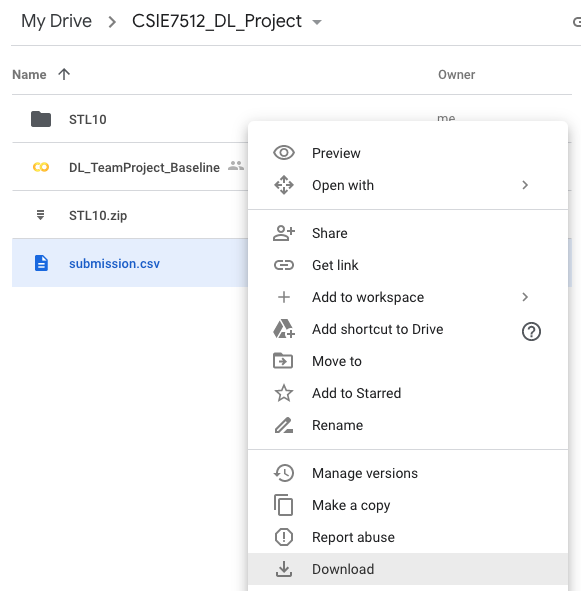

2. Go to [our kaggle submission link](https://www.kaggle.com/t/a5ea909a4294477d82a1ba88c10abe61) and click `Submit Predicitions` button  
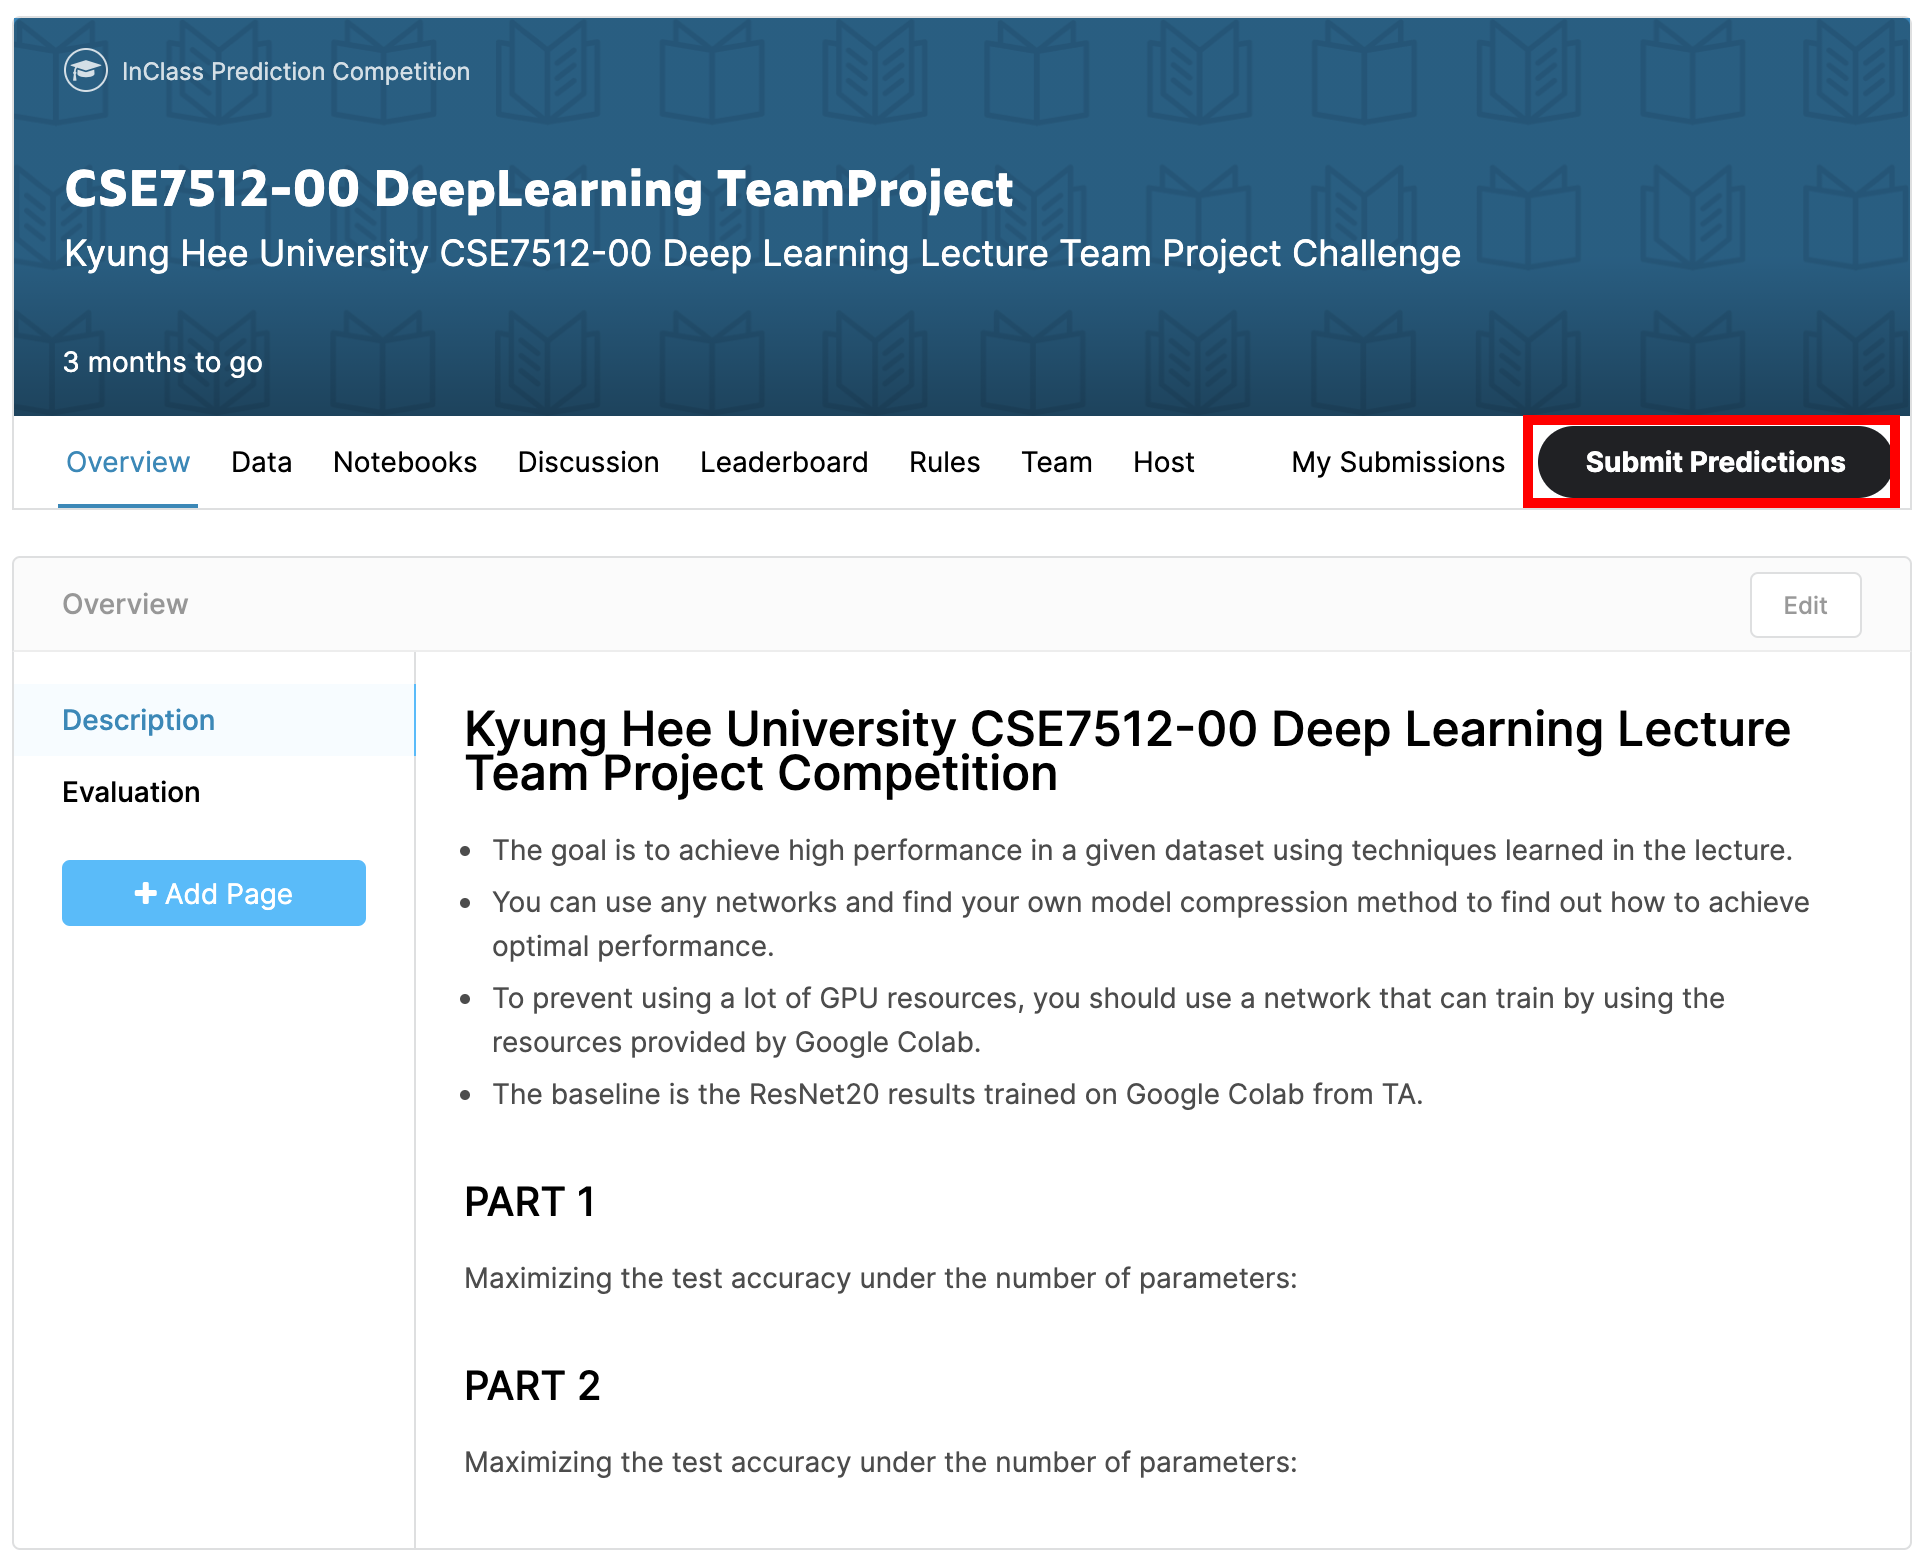

3. Upload Submission `csv` file and click `make submission` button  
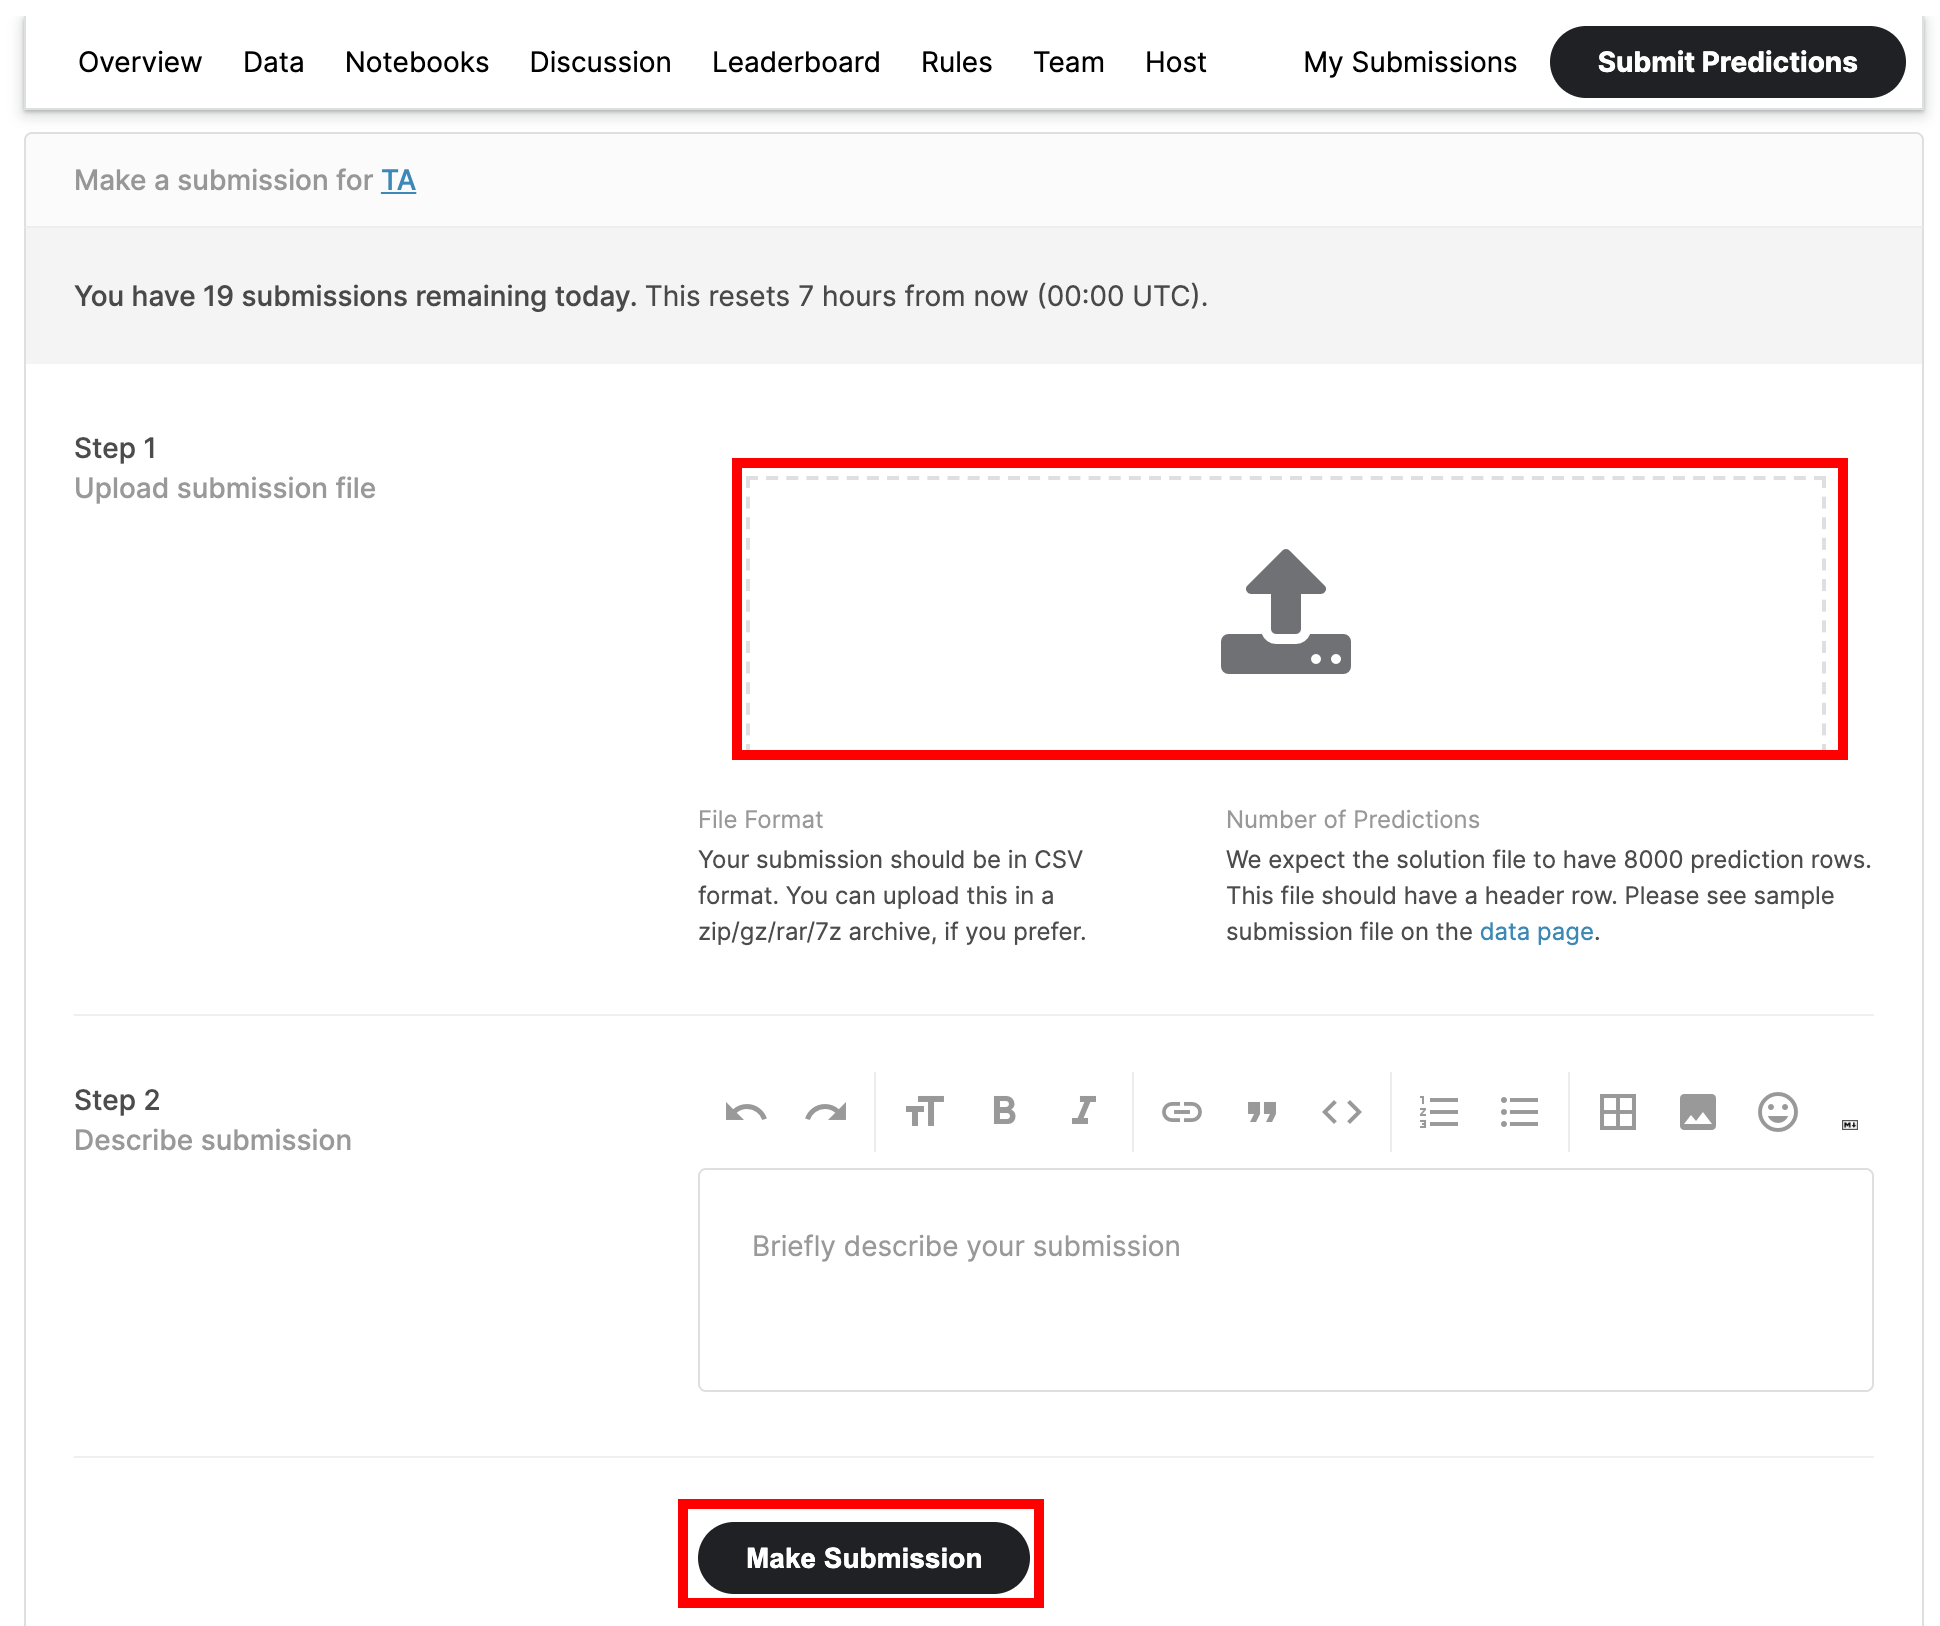

